In [1]:
from PIL import Image
import os
from transformers import SamProcessor,SamModel 
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy.ndimage import binary_dilation, label, sum as ndi_sum
import numpy as np
from scipy.ndimage import label, binary_dilation, sum as ndi_sum
import cv2
import matplotlib.pyplot as plt



In [2]:

device = "cuda:1" if torch.cuda.is_available() else "cpu"

# load the pretrained weights for finetuning
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")
# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        print(name)
        param.requires_grad_(False)   
state_dict = torch.load("best_weights_v2.pth")
model.load_state_dict(state_dict)
model.to(device)

vision_encoder.pos_embed
vision_encoder.patch_embed.projection.weight
vision_encoder.patch_embed.projection.bias
vision_encoder.layers.0.layer_norm1.weight
vision_encoder.layers.0.layer_norm1.bias
vision_encoder.layers.0.attn.rel_pos_h
vision_encoder.layers.0.attn.rel_pos_w
vision_encoder.layers.0.attn.qkv.weight
vision_encoder.layers.0.attn.qkv.bias
vision_encoder.layers.0.attn.proj.weight
vision_encoder.layers.0.attn.proj.bias
vision_encoder.layers.0.layer_norm2.weight
vision_encoder.layers.0.layer_norm2.bias
vision_encoder.layers.0.mlp.lin1.weight
vision_encoder.layers.0.mlp.lin1.bias
vision_encoder.layers.0.mlp.lin2.weight
vision_encoder.layers.0.mlp.lin2.bias
vision_encoder.layers.1.layer_norm1.weight
vision_encoder.layers.1.layer_norm1.bias
vision_encoder.layers.1.attn.rel_pos_h
vision_encoder.layers.1.attn.rel_pos_w
vision_encoder.layers.1.attn.qkv.weight
vision_encoder.layers.1.attn.qkv.bias
vision_encoder.layers.1.attn.proj.weight
vision_encoder.layers.1.attn.proj.bias
vision_

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [3]:
import glob
from monai.transforms import (Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, CenterSpatialCropd,
                              ScaleIntensityRanged, ResizeD,SpatialPadd)
# Initialize dictionary for storing image and label paths
data_paths = {}
base_dir = './dataset_512'
datasets = ['train', 'val', 'test']
data_types = ['2d_images', '2d_masks']
# Create directories and print the number of images and masks in each
for dataset in datasets:
    for data_type in data_types:
        # Construct the directory path
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}_512')
        
        # Find images and labels in the directory
        files = sorted(glob.glob(os.path.join(dir_path, "*.nii.gz")))
        
        # Store the image and label paths in the dictionary
        data_paths[f'{dataset}_{data_type.split("_")[1]}'] = files

print('Number of training images', len(data_paths['train_images']))
print('Number of validation images', len(data_paths['val_images']))
print('Number of test images', len(data_paths['test_images']))

Number of training images 790
Number of validation images 301
Number of test images 1208


In [4]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 512, 512] # if there is no mask in the array, set bbox to image size

In [5]:
class SAMDataset2(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transforms = Compose([
            LoadImaged(keys=['img', 'label']),
            EnsureChannelFirstd(keys=['img', 'label']),
            Orientationd(keys=['img', 'label'], axcodes='RA'),
#             Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),
#             CenterSpatialCropd(keys=['img', 'label'], roi_size=(256,256)),
            ResizeD(keys=['img', 'label'], spatial_size=(256,256), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=['img'], a_min=-1000, a_max=2000, 
                         b_min=0.0, b_max=255.0, clip=True), 
            ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, 
                         b_min=0.0, b_max=1.0, clip=True), 
#             SpatialPadd(keys=["img", "label"], spatial_size=(256,256))
        ])
        
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        data_dict = self.transforms({'img': image_path, 'label': mask_path})

        image = data_dict['img'].squeeze()
        ground_truth_mask = data_dict['label'].squeeze()

        image = image.astype(np.uint8)

        array_rgb = np.dstack((image, image, image))
        
        image_rgb = Image.fromarray(array_rgb)
        
        ground_truth_mask[ground_truth_mask < 0] = 1
        prompt = get_bounding_box(ground_truth_mask)
        
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))
        inputs["image_name"] = os.path.basename(image_path).replace('.nii.gz', '.png') # Change the extension

        return inputs

test_dataset = SAMDataset2(image_paths=data_paths['test_images'], mask_paths=data_paths['test_masks'], processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)






In [6]:

if not os.path.exists('./dataset_512/infer_new_sam_b'):
    os.makedirs('./dataset_512/infer_new_sam_b')

with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_dataloader)):
        outputs = model(pixel_values=batch["pixel_values"].cuda(1),
                        input_boxes=batch["input_boxes"].cuda(1),
                        multimask_output=False)

        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        labeled, num_features = label(medsam_seg)
        border_mask = np.zeros_like(medsam_seg)
        border_mask[:, 0] = 1
        border_mask[0, :] = 1
        border_mask[:, -1] = 1
        border_mask[-1, :] = 1

        touching_border = np.unique(labeled * binary_dilation(border_mask))
        for region in touching_border:
            if region != 0:
                medsam_seg[labeled == region] = 0
        for i in range(1, num_features + 1):
            area = ndi_sum(labeled == i)
            if area <= 4:
                medsam_seg[labeled == i] = 0
        original_image = batch["pixel_values"][0, 1].cpu().numpy().astype(np.uint8)
        # print(original_image.shape)
        edges_original = cv2.Canny(original_image, 50, 200)
        
        kernel = np.ones((3,3),np.uint8)
        dilated = cv2.dilate(edges_original, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        
        mask = np.zeros_like(edges_original)
        # print(mask.shape)
        # 在mask上画出最大的轮廓
        cv2.drawContours(mask, [max_contour],-1, (255), thickness=cv2.FILLED)
        # 创建一个比输入图像大2的掩码，用于floodFill函数
        h, w = mask.shape[:2]
        mask_floodfill = np.zeros((h+2, w+2), np.uint8)
        # floodFill函数会改变输入图像，所以我们使用它的副本
        mask_floodfill_copy = mask.copy()
        # 找到一个种子点
        seed_point = (w//2, h//2)
        # 执行floodFill函数，将与种子点连通的区域填充为白色
        cv2.floodFill(mask_floodfill_copy, mask_floodfill, seed_point, 255)
        final_mask = mask | mask_floodfill_copy
        final_mask = cv2.resize(final_mask, (256, 256))
        # print(final_mask.shape)
        # print(medsam_seg.shape)
       
        masked_seg = cv2.bitwise_or(medsam_seg,medsam_seg, mask=final_mask)
        final_mask = cv2.resize(masked_seg, (512, 512))
        closed_seg = cv2.morphologyEx(masked_seg, cv2.MORPH_CLOSE, kernel)

        result_image_name = os.path.join('./dataset_512/infer_new_sam_b', batch["image_name"][0])
        result_image = Image.fromarray((closed_seg * 255).astype(np.uint8))
        result_image.save(result_image_name)

        # plt.figure(figsize=(12,4))
        # plt.subplot(1,3,1)
        # plt.imshow(batch["pixel_values"][0,1], cmap='gray')
        # plt.title('original_image')
        # plt.axis('off')
        # plt.subplot(1,3,2)
        # plt.imshow(batch["ground_truth_mask"][0], cmap='copper')
        # plt.title('ground_truth_masks')
        # plt.axis('off')
        # plt.subplot(1,3,3)
        # plt.imshow(closed_seg, cmap='copper')
        # plt.title('after_canny')
        # plt.axis('off')
        # plt.tight_layout()
        # plt.savefig(result_image_name)



100%|██████████| 1208/1208 [04:29<00:00,  4.49it/s]


Shape of the input array: (512, 512)
lungmask 2024-01-08 11:23:34 Postprocessing


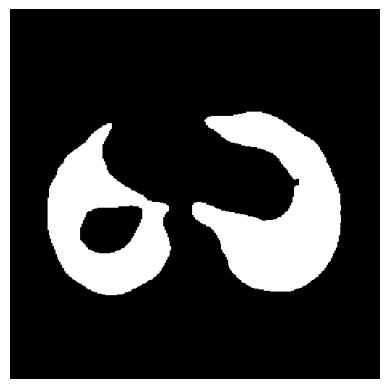

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
from lungmask import LMInferer
import SimpleITK as sitk
from monai.transforms import Compose, EnsureChannelFirst, Orientation, Resize, ScaleIntensityRange,LoadImaged

inferer = LMInferer(tqdm_disable=True)

input_image = sitk.ReadImage("./dataset_512/test_2d_images_512/IMG_0002_65.nii.gz")
# input_image = sitk.Cast(input_image, sitk.sitkFloat32)
input_array = sitk.GetArrayFromImage(input_image)
# input=LoadImaged("./dataset_512/test_2d_images_512/IMG_0002_65.nii.gz")
# transformations = Compose([
#     # EnsureChannelFirst(),
#     Orientation(axcodes='RA'),
#     Resize(spatial_size=(256,256), mode="bilinear"),
#     ScaleIntensityRange(a_min=-1000, a_max=2000, b_min=0.0, b_max=255.0, clip=True)
# ])
# # Apply the transformations
# input_array = transformations(input_array)
# Check the shape of the array
print(f"Shape of the input array: {input_array.shape}")

# volume_3d_image = sitk.GetImageFromArray(input_array)

#     # Now you can apply the lungmask package to the 3D image
# segmentation = inferer.apply(volume_3d_image)

# # If the input array is 4D (e.g., (time, z, y, x)), select a 3D volume
# if len(input_array.shape) == 4:
#     # Select the first time point as an example
#     volume_3d = input_array[0]
if len(input_array.shape)==2:
    volume_3d=input_array[np.newaxis,:,:]
    # Convert the 3D volume back to a SimpleITK image
    volume_3d_image = sitk.GetImageFromArray(volume_3d)
    # Now you can apply the lungmask package to the 3D image
    segmentation = inferer.apply(volume_3d_image)

segmentation = segmentation.transpose((2, 1, 0)) 
corrected_segmentation = np.fliplr(segmentation)
# slice_index=100
# result_image_name_lungmask = os.path.join(output_dir, batch["image_name"][0])
# plt.imshow(segmentation, cmap='gray')
# print(corrected_segmentation[300])
normalized_volume = ((volume_3d - volume_3d.min()) / (volume_3d.max() - volume_3d.min()) * 255).astype(np.uint8)
edges_original = cv2.Canny(normalized_volume, 50, 200)
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(edges_original, kernel, iterations=1)
contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)

mask = np.zeros_like(edges_original)
# 在mask上画出最大的轮廓
cv2.drawContours(mask, [max_contour],-1, (255), thickness=cv2.FILLED)
# 创建一个比输入图像大2的掩码，用于floodFill函数
h, w = mask.shape[:2]
mask_floodfill = np.zeros((h+2, w+2), np.uint8)
# floodFill函数会改变输入图像，所以我们使用它的副本
mask_floodfill_copy = mask.copy()
# 找到一个种子点
seed_point = (w//2, h//2)
# 执行floodFill函数，将与种子点连通的区域填充为白色
cv2.floodFill(mask_floodfill_copy, mask_floodfill, seed_point, 255)
final_mask = mask | mask_floodfill_copy
final_mask = cv2.resize(final_mask, (256, 256))

# Ensure both images have the same size
final_mask = cv2.resize(final_mask, (corrected_segmentation.shape[1], corrected_segmentation.shape[0]))

# Ensure both images have the same data type (8-bit unsigned integer)
final_mask = final_mask.astype(np.uint8)
masked_seg = cv2.bitwise_or(corrected_segmentation,corrected_segmentation, mask=final_mask)
closed_seg = cv2.morphologyEx(masked_seg, cv2.MORPH_CLOSE, kernel)

white_mask = closed_seg > 0
closed_seg[white_mask] = 255

plt.imshow(closed_seg,cmap='gray')
plt.axis('off')
plt.show()
# print(closed_seg)
# # print(input_image)
# # Apply lung segmentation using lungmask
# segmentation = inferer.apply(input_image)

100%|██████████| 1208/1208 [5:45:25<00:00, 17.16s/it]


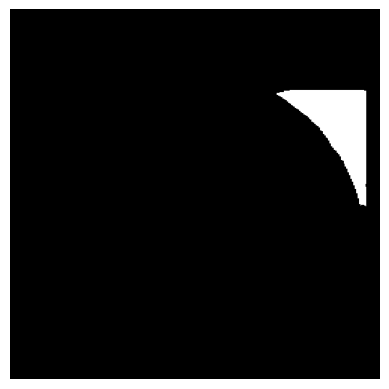

In [23]:
from lungmask import LMInferer
import SimpleITK as sitk
from IPython.display import clear_output

# Create the lungmask inferer
inferer = LMInferer(modelname='LTRCLobes', fillmodel='R231',tqdm_disable=True)

# Define the input and output directories
input_dir = "./dataset_512/test_2d_images_512/"
output_dir = "./dataset_512/infer_new_lungmask"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List of test file paths
test_files = [os.path.join(input_dir, filename) for filename in os.listdir(input_dir) if filename.endswith('.nii.gz')]

# Perform inference for each test file
for test_file in tqdm(test_files):
    # Read the NIfTI file using SimpleITK
    input_image = sitk.ReadImage(test_file)
    input_array = sitk.GetArrayFromImage(input_image)

    if len(input_array.shape)==2:
        volume_3d=input_array[np.newaxis,:,:]
        # Convert the 3D volume back to a SimpleITK image
        volume_3d_image = sitk.GetImageFromArray(volume_3d)
        # Now you can apply the lungmask package to the 3D image
        segmentation = inferer.apply(volume_3d_image)

    segmentation = segmentation.transpose((2, 1, 0)) 
    corrected_segmentation = np.fliplr(segmentation)
    
    white_mask = corrected_segmentation > 0
    corrected_segmentation[white_mask] = 255

    normalized_volume = ((volume_3d - volume_3d.min()) / (volume_3d.max() - volume_3d.min()) * 255).astype(np.uint8)
    edges_original = cv2.Canny(normalized_volume, 50, 200)
    kernel = np.ones((3,3),np.uint8)
    dilated = cv2.dilate(edges_original, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(edges_original)
    # 在mask上画出最大的轮廓
    cv2.drawContours(mask, [max_contour],-1, (255), thickness=cv2.FILLED)
    # 创建一个比输入图像大2的掩码，用于floodFill函数
    h, w = mask.shape[:2]
    mask_floodfill = np.zeros((h+2, w+2), np.uint8)
    # floodFill函数会改变输入图像，所以我们使用它的副本
    mask_floodfill_copy = mask.copy()
    # 找到一个种子点
    seed_point = (w//2, h//2)
    # 执行floodFill函数，将与种子点连通的区域填充为白色
    cv2.floodFill(mask_floodfill_copy, mask_floodfill, seed_point, 255)
    final_mask = mask | mask_floodfill_copy
    final_mask = cv2.resize(final_mask, (256, 256))

    # Ensure both images have the same size
    final_mask = cv2.resize(final_mask, (corrected_segmentation.shape[1], corrected_segmentation.shape[0]))

    # Ensure both images have the same data type (8-bit unsigned integer)
    final_mask = final_mask.astype(np.uint8)
    masked_seg = cv2.bitwise_or(corrected_segmentation,corrected_segmentation, mask=final_mask)
    closed_seg = cv2.morphologyEx(masked_seg, cv2.MORPH_CLOSE, kernel)
    # Save the result
    # print(test_file)
    # break
    png_filename = os.path.basename(test_file).rsplit('.', 2)[0] + '.png'
    result_image_path = os.path.join(output_dir, png_filename)
    plt.imshow(closed_seg, cmap='gray')
    plt.axis('off')
    plt.savefig(result_image_path)
    clear_output()


In [20]:
# from lungmask import LMInferer
# import SimpleITK as sitk

# # Create the lungmask inferer
# inferer = LMInferer(tqdm_disable=True)

# # Define the input and output directories
# input_dir = "./dataset_512/test_2d_images_512/"
# output_dir = "./dataset_512/infer_new_lungmask"

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # # List of test file paths
# # test_files = [os.path.join(input_dir, filename) for filename in os.listdir(input_dir) if filename.endswith('.nii.gz')]

# # Perform inference for each test file
# # for test_file in tqdm(test_files):
# with torch.no_grad():
#     # Read the NIfTI file using SimpleITK
#    for idx, batch in enumerate(tqdm(test_dataloader)):
#         # print(batch)
#         # image_rgb = batch["pixel_values"].numpy().squeeze().astype(np.uint8)
#         original_image = batch["pixel_values"][0].squeeze().numpy().astype(np.uint8)
#         print(original_image.shape)
#         # # Apply lung segmentation using lungmask
#         # lung_mask = inferer.apply(image_rgb)

#         # # Convert the SimpleITK segmentation to NumPy array
#         # lung_mask_np = sitk.GetArrayFromImage(lung_mask)
#         lung_mask_np=inferer.apply(original_image)
#         # print(type(lung_mask_np))
#         lung_mask_np = lung_mask_np.transpose((1, 2, 0))  # If lung_mask_np is a numpy array
#         # Additional post-processing steps if needed
#         # ...

#         # Save the result
#         result_image_name_lungmask = os.path.join(output_dir, batch["image_name"][0])
#         plt.imshow(lung_mask_np, cmap='gray')
#         plt.axis('off')
#         plt.savefig(result_image_name_lungmask)